# POC Loan Rates Forecast Model

# 1. Executive Summary

# 2. Model Information

# 3. Conceptual Soundness 

# 4. Model Development

## 4.1. Data Engineering

### 4.1.1. Data Collection

#### Setup

In [1]:
# System libraries
import glob

# ML libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from arch.unitroot import PhillipsPerron, DFGLS
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Load FRED Data

In [2]:
def merge_fred_csv_files(file_pattern):
    # Use glob to find all files matching the specified pattern
    file_list = glob.glob(file_pattern)

    # Initialize an empty list to store individual DataFrames
    dataframes = []

    # Iterate through each file in the file list
    for file in file_list:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')

        # Add the DataFrame to the list of DataFrames
        dataframes.append(df)

    # Merge all the DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dataframes, axis=1)

    return merged_df


In [3]:
file_pattern = '../datasets/fred/*.csv'
df = merge_fred_csv_files(file_pattern)
display(df)

,GDPC1,GS5,GS10,GS3,MORTGAGE30US,UNRATE,CPIAUCSL,FEDFUNDS,GDP
DATE,,,,,,,,,
1947-01-01,2034.450,NaN,NaN,NaN,NaN,NaN,21.48,NaN,243.164
1947-02-01,NaN,NaN,NaN,NaN,NaN,NaN,21.62,NaN,NaN
1947-03-01,NaN,NaN,NaN,NaN,NaN,NaN,22.00,NaN,NaN
1947-04-01,2029.024,NaN,NaN,NaN,NaN,NaN,22.00,NaN,245.968
1947-05-01,NaN,NaN,NaN,NaN,NaN,NaN,21.95,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-04-01,NaN,NaN,3.46,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,NaN,NaN,NaN,NaN,6.28,NaN,NaN,NaN,NaN
2023-04-13,NaN,NaN,NaN,NaN,6.27,NaN,NaN,NaN,NaN


Preselection of variables.

In [4]:
selected_cols = ['MORTGAGE30US', 'UNRATE', 'GS10', 'FEDFUNDS'] 
df = df[selected_cols]

Plot time series.

In [5]:
def plot_time_series(df, cols_to_plot=None, title=''):
    """
    Plot multiple time-series in the same axes using seaborn.

    :param df: DataFrame with time-series data
    :param cols_to_plot: List of column names to plot. If None, plot all columns in df.
    :param title: Title of the plot, default is ''
    """
    if cols_to_plot is None:
        cols_to_plot = df.columns.tolist()

    # Create a new DataFrame with the columns to plot
    plot_df = df[cols_to_plot]

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the time-series data
    plt.figure(figsize=(12, 6))
    for col in plot_df.columns:
        sns.lineplot(data=plot_df[col], label=col)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()


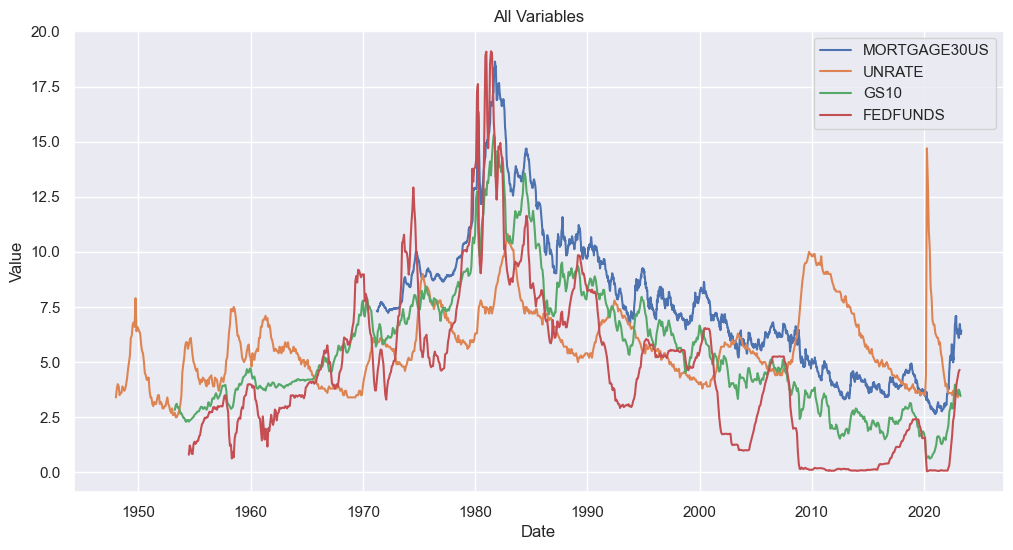

In [6]:
plot_time_series(df, title='All Variables')

### 4.1.2. Data Description

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3551 entries, 1947-01-01 to 2023-04-27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MORTGAGE30US  2718 non-null   float64
 1   UNRATE        903 non-null    float64
 2   GS10          841 non-null    float64
 3   FEDFUNDS      825 non-null    float64
dtypes: float64(4)
memory usage: 138.7 KB


### 4.1.3. Data Quality

#### Frequency of Series 

Distribution of frequencies in the data.

In [8]:
def plot_time_difference_frequency(df):
    # Calculate the time differences between consecutive entries
    time_diff = df.index.to_series().diff().dropna()

    # Convert the time differences to a suitable unit (e.g., days)
    time_diff_days = time_diff.dt.total_seconds() / (60 * 60 * 24)

    # Create a DataFrame with the time differences
    time_diff_df = pd.DataFrame({'Time Differences (Days)': time_diff_days})

    # Plot the frequency distribution of the time differences
    sns.histplot(data=time_diff_df, x='Time Differences (Days)', bins=50, kde=False)
    plt.xlabel('Time Differences (Days)')
    plt.ylabel('Frequency')
    plt.show()

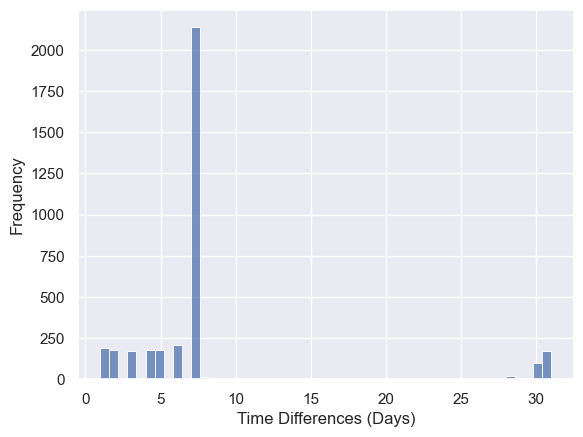

In [9]:
plot_time_difference_frequency(df)

Identify frequencies for each variable.

In [10]:
def identify_frequencies(df):
    """
    Identify the frequency of each series in the DataFrame.

    :param df: Time-series DataFrame
    :return: DataFrame with two columns: 'Variable' and 'Frequency'
    """
    frequencies = []
    for column in df.columns:
        series = df[column].dropna()
        if not series.empty:
            freq = pd.infer_freq(series.index)
            if freq == 'MS' or freq == 'M':
                label = 'Monthly'
            elif freq == 'Q':
                label = 'Quarterly'
            elif freq == 'A':
                label = 'Yearly'
            else:
                label = freq
        else:
            label = None

        frequencies.append({'Variable': column, 'Frequency': label})

    freq_df = pd.DataFrame(frequencies)

    return freq_df

In [11]:
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,None
1,UNRATE,Monthly
2,GS10,Monthly
3,FEDFUNDS,Monthly


Handling frequencies.

In [12]:
df = df.resample('MS').last()
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,Monthly
1,UNRATE,Monthly
2,GS10,Monthly
3,FEDFUNDS,Monthly


#### Missing Values

**Step 1: Identify Missing Values**

Total number of missing values.

In [13]:
def plot_missing_values_bar(df):
    """
    Plot a bar chart displaying the total number of missing values per variable (column) in a time-series DataFrame using seaborn.
    
    :param df: Time-series DataFrame
    """
    # Calculate the total number of missing values per column
    missing_values = df.isnull().sum()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Variables (Columns)')
    plt.ylabel('Number of Missing Values')
    plt.title('Total Number of Missing Values per Variable')
    plt.show()

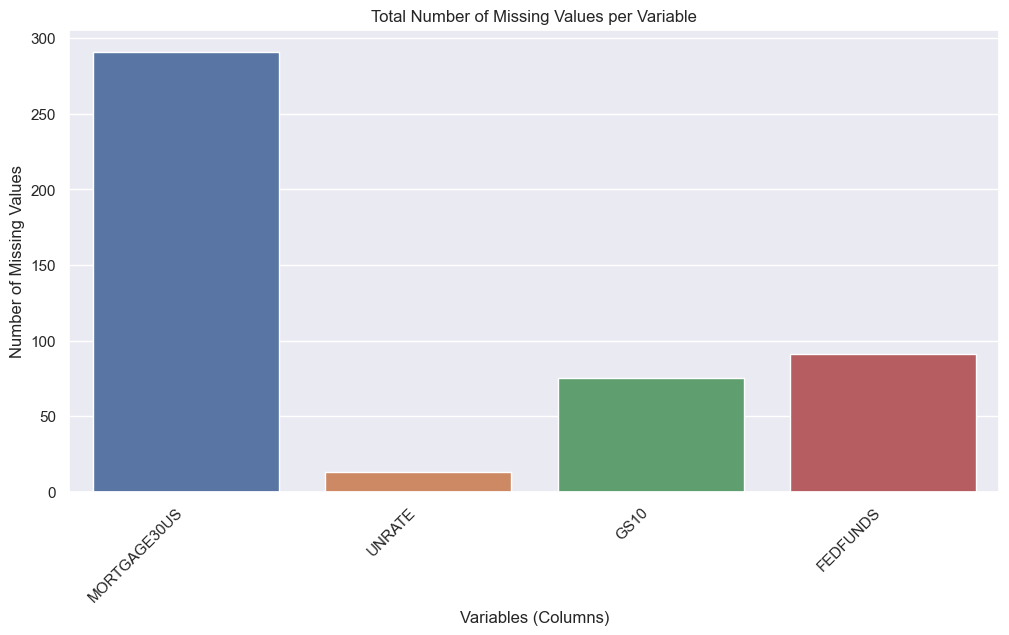

In [14]:
plot_missing_values_bar(df)

Heatmap of missing values.

In [15]:
def plot_missing_values_heatmap(df, start_year=None, end_year=None):
    """
    Plot a heatmap of missing values with actual years in rows using seaborn.

    :param df: Time-series DataFrame
    :param start_year: Start year for zooming in, defaults to None
    :param end_year: End year for zooming in, defaults to None
    """
    # Filter the DataFrame based on the specified start_year and end_year
    if start_year:
        df = df[df.index.year >= start_year]
    if end_year:
        df = df[df.index.year <= end_year]

    # Create a boolean mask for missing values
    missing_mask = df.isnull()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(missing_mask.T, cmap='viridis', cbar=False, xticklabels=False)

    # Add actual years on the x-axis
    years = df.index.year.unique()
    xticks = [df.index.get_loc(df.index[df.index.year == year][0]) for year in years]
    plt.xticks(xticks, years, rotation=45, ha='right')

    plt.ylabel('Columns')
    plt.xlabel('Rows (Years)')
    plt.title('Missing Values Heatmap with Actual Years in Rows')
    plt.show()

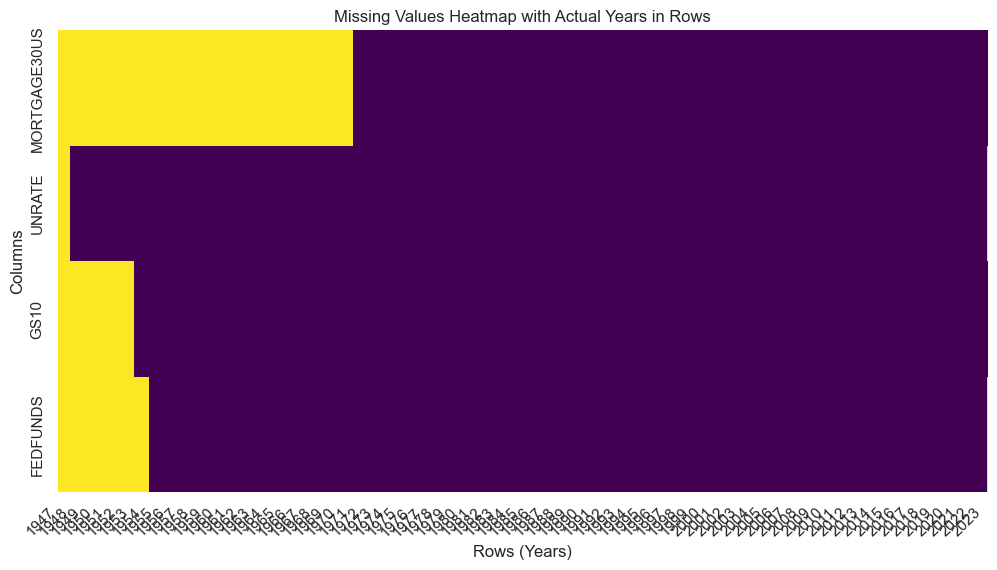

In [16]:
plot_missing_values_heatmap(df)

**Step 2: Handling Missing Values**

Drop missing values.

In [17]:
df = df.dropna()

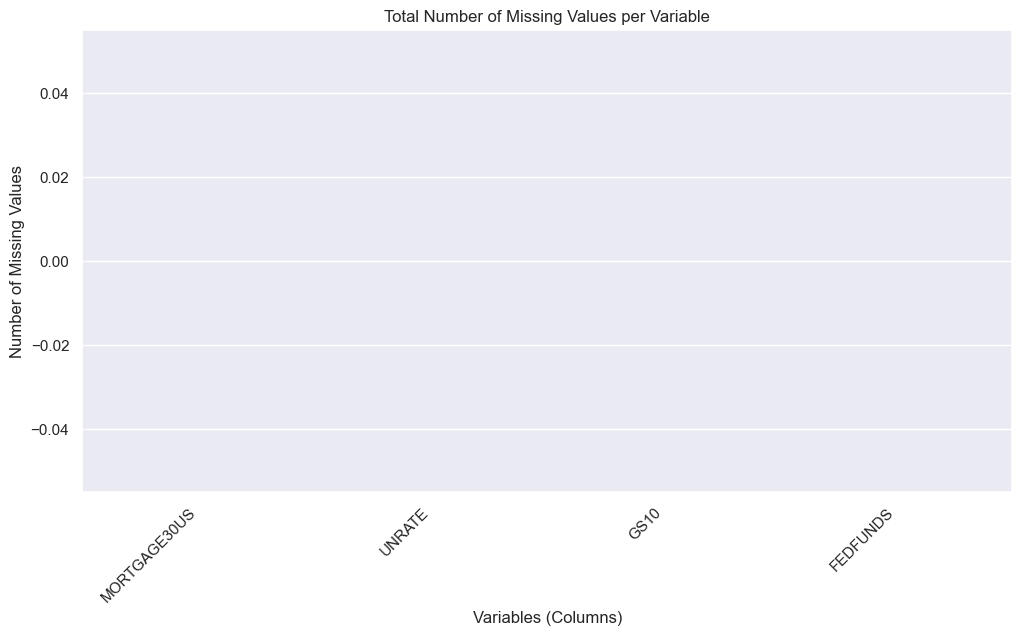

In [18]:
plot_missing_values_bar(df)

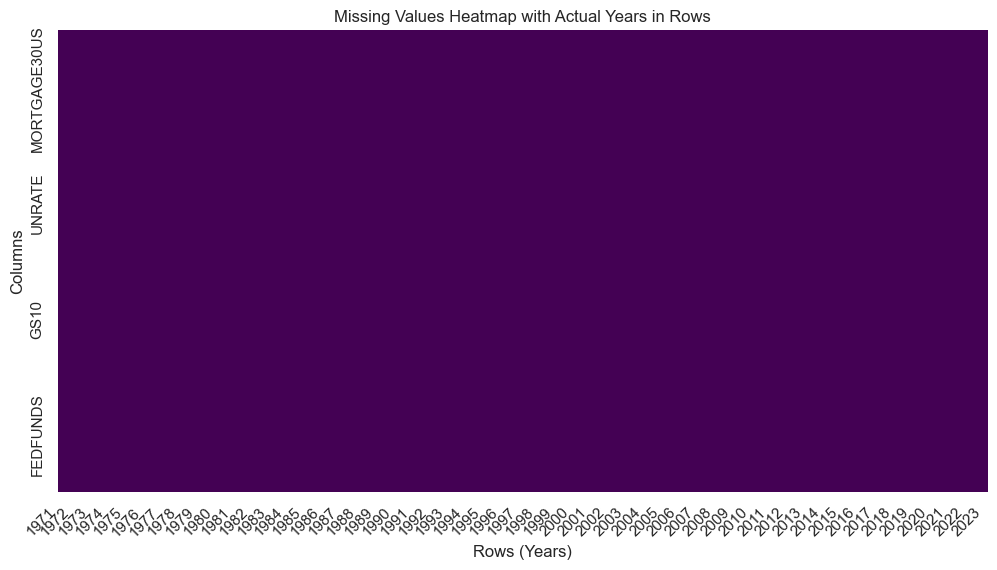

In [19]:
plot_missing_values_heatmap(df)

#### Outliers

**Step 1: Identify Outliers**

In [20]:
def identify_outliers(df, threshold=3):
    z_scores = pd.DataFrame(stats.zscore(df), index=df.index, columns=df.columns)
    outliers = z_scores[(z_scores.abs() > threshold).any(axis=1)]
    
    outlier_table = []
    for idx, row in outliers.iterrows():
        for col in df.columns:
            if abs(row[col]) > threshold:
                outlier_table.append({"Variable": col, "z-score": row[col], "Threshold": threshold, "Date": idx})
                
    return pd.DataFrame(outlier_table)


In [22]:
outliers_table = identify_outliers(df, threshold=3)
display(outliers_table)

,Variable,z-score,Threshold,Date
0,FEDFUNDS,3.106442,3,1980-03-01
1,FEDFUNDS,3.212296,3,1980-04-01
2,FEDFUNDS,3.537417,3,1980-12-01
3,FEDFUNDS,3.582783,3,1981-01-01
4,FEDFUNDS,3.441645,3,1981-05-01
5,FEDFUNDS,3.587823,3,1981-06-01
6,FEDFUNDS,3.572701,3,1981-07-01
7,FEDFUNDS,3.265222,3,1981-08-01
8,MORTGAGE30US,3.246766,3,1981-09-01
9,MORTGAGE30US,3.271251,3,1981-10-01


Plot outliers.

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_outliers(df, outliers_table, use_subplots=False):
    sns.set(style="darkgrid")
    
    if use_subplots:
        n_variables = len(df.columns)
        fig, axes = plt.subplots(n_variables, 1, figsize=(12, 3 * n_variables), sharex=True)
        
        for i, col in enumerate(df.columns):
            sns.lineplot(data=df, x=df.index, y=col, ax=axes[i], label=col)
            
            variable_outliers = outliers_table[outliers_table["Variable"] == col]
            for idx, row in variable_outliers.iterrows():
                date = row["Date"]
                outlier_value = df.loc[date, col]
                axes[i].scatter(date, outlier_value, marker="o", s=100, c="red", label="Outlier" if idx == 0 else "")
            
            axes[i].legend()
            axes[i].set_ylabel("Value")
            axes[i].set_title(f"Time Series with Outliers for {col}")

        plt.xlabel("Date")
        plt.tight_layout()

    else:
        plt.figure(figsize=(12, 3))
        for col in df.columns:
            sns.lineplot(data=df, x=df.index, y=col, label=col)
        
        plotted_outlier_variables = set()
        for idx, row in outliers_table.iterrows():
            date = row["Date"]
            variable = row["Variable"]
            outlier_value = df.loc[date, variable]
            if variable not in plotted_outlier_variables:
                plt.scatter(date, outlier_value, marker="o", s=100, c="red", label=f"Outlier ({variable})")
                plotted_outlier_variables.add(variable)
            else:
                plt.scatter(date, outlier_value, marker="o", s=100, c="red")

        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title("Time Series with Outliers")
    
    plt.show()


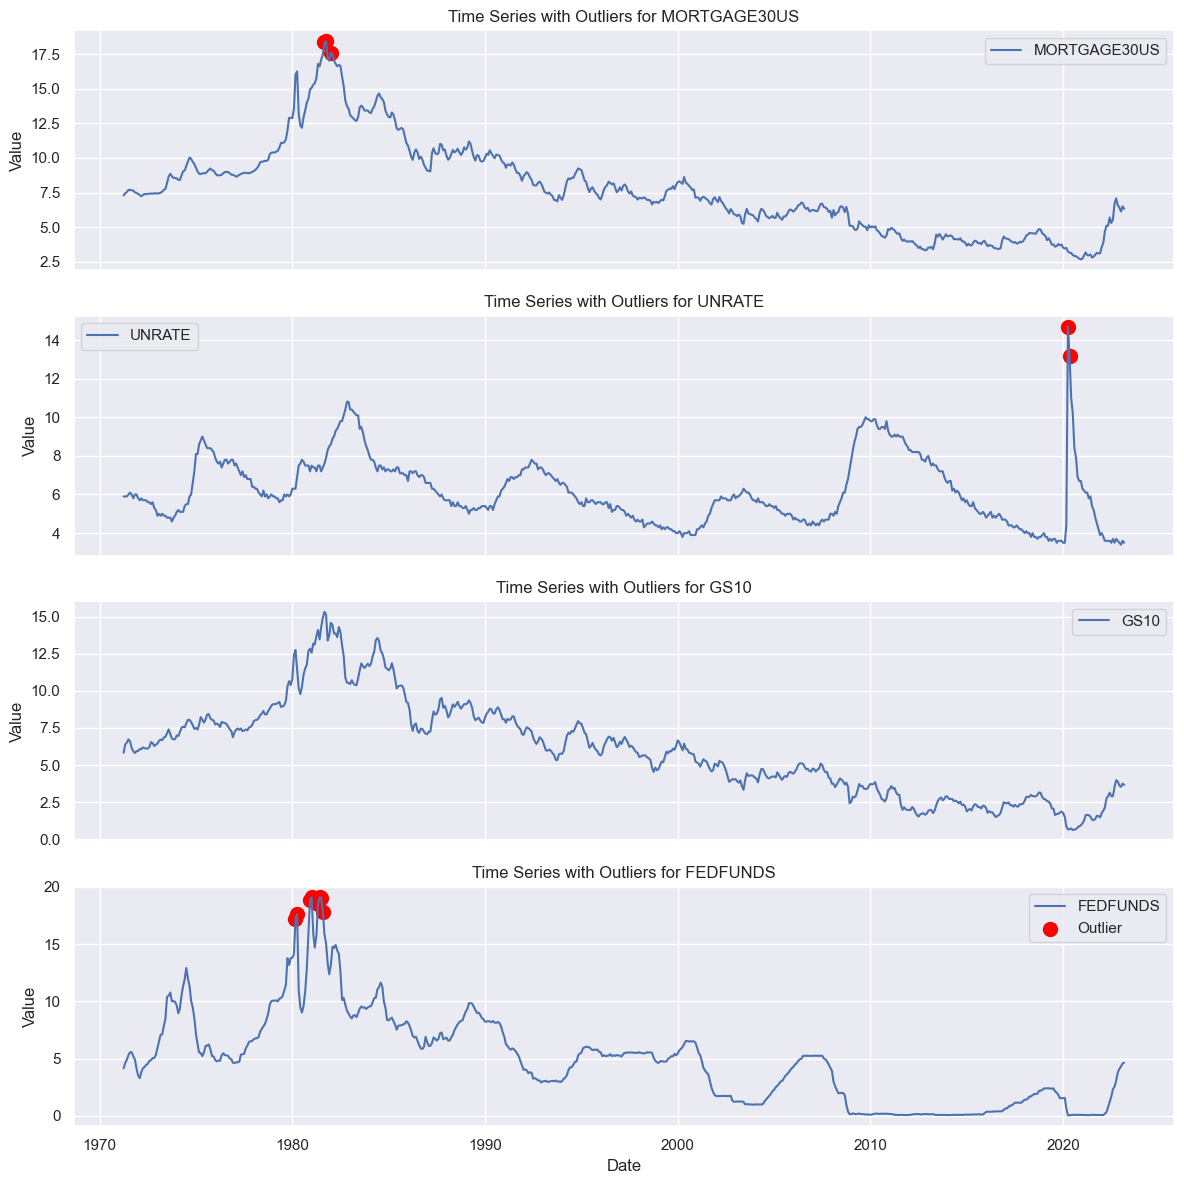

In [33]:
plot_outliers(df, outliers_table, use_subplots=True)

**Step 2: Handling Outliers**

## 4.2. Exploratory Data Analysis

### 4.2.1. Univariate Analysis

#### Visual Inspection

Line plots.

In [ ]:
plot_time_series(df, title='All Variables')

#### Seasonality 

**Step 1: Compute Seasonal Decomposition**

In [ ]:
def compute_seasonal_decomposition(data, model='additive'):
    """
    Compute seasonal decomposition for all time-series in a DataFrame and store all the components in a new DataFrame.
    
    :param data: DataFrame with time-series data
    :param period: Number of observations in each seasonal period
    :return: DataFrame with seasonal, trend, and residual components for all time-series in the input DataFrame
    """
    # Initialize an empty DataFrame to store the components for each time-series
    decomp_df = pd.DataFrame()

    # Loop over each column in the input DataFrame and perform seasonal decomposition
    for col in data.columns:
        res = seasonal_decompose(data[col], model=model)
        decomp_df[f'{col}_seasonal'] = res.seasonal
        decomp_df[f'{col}_trend'] = res.trend
        decomp_df[f'{col}_residual'] = res.resid

    # Set the index of the decomposed DataFrame to be the same as the input DataFrame
    decomp_df.index = data.index

    return decomp_df


In [ ]:
decomp_df = compute_seasonal_decomposition(df)

**Step 2: Visualize Seasonal Decomposition**

In [ ]:
def plot_seasonal_components(decomp_df):
    """
    Plot all seasonal, trend, and residual components for each variable in a DataFrame.
    
    :param decomp_df: DataFrame with seasonal, trend, and residual components for each variable
    """
    # Initialize a figure with subplots for each variable and component
    fig, axs = plt.subplots(nrows=len(decomp_df.columns) // 3, ncols=3, figsize=(12, 4 * (len(decomp_df.columns) // 3)))

    # Loop over each variable in the input DataFrame and plot the seasonal, trend, and residual components
    for i, col in enumerate(decomp_df.columns[::3]):
        axs[i, 0].plot(decomp_df.index, decomp_df[f'{col}'])
        axs[i, 0].set_title(f'Seasonal: {col[:-9]}')
        axs[i, 1].plot(decomp_df.index, decomp_df[f'{col[:-9]}_trend'])
        axs[i, 1].set_title(f'Trend: {col[:-9]}')
        axs[i, 2].plot(decomp_df.index, decomp_df[f'{col[:-9]}_residual'])
        axs[i, 2].set_title(f'Residual: {col[:-9]}')

    # Set the figure title
    fig.suptitle('Seasonal Decomposition', fontsize=16)

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
plot_seasonal_components(decomp_df)

**Step 3: Residual Analysis**

#### Stationarity

**Step 1: Compute Unit Root Tests on Levels**

In [ ]:
def test_stationarity(data, threshold=0.05):
    """
    Perform multiple stationarity tests on each time series in a DataFrame.
    
    :param data: DataFrame with time-series data
    :return: DataFrame with test results (Variable, Test, p-value, Threshold, Pass/Fail, Decision)
    """
    # Initialize an empty DataFrame to store the test results
    test_results = pd.DataFrame(columns=['Variable', 'Test', 'p-value', 'Threshold', 'Pass/Fail', 'Decision'])

    # Loop over each column in the input DataFrame and perform stationarity tests
    for col in data.columns:
        # Perform the ADF test
        adf_result = adfuller(data[col], autolag='AIC')
        adf_pvalue = adf_result[1]
        adf_pass_fail = adf_pvalue < threshold
        adf_decision = 'Stationary' if adf_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'ADF',
            'p-value': adf_pvalue,
            'Threshold': threshold,
            'Pass/Fail': adf_pass_fail,
            'Decision': adf_decision
        }, ignore_index=True)

        # Perform the KPSS test
        kpss_result = kpss(data[col], regression='c', nlags='auto')
        kpss_pvalue = kpss_result[1]
        kpss_pass_fail = kpss_pvalue > threshold
        kpss_decision = 'Stationary' if kpss_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'KPSS',
            'p-value': kpss_pvalue,
            'Threshold': threshold,
            'Pass/Fail': kpss_pass_fail,
            'Decision': kpss_decision
        }, ignore_index=True)

        # Perform the Phillips-Perron test
        pp_result = PhillipsPerron(data[col], trend='ct')
        pp_pvalue = pp_result.pvalue
        pp_threshold = threshold
        pp_pass_fail = pp_pvalue < pp_threshold
        pp_decision = 'Stationary' if pp_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'PhillipsPerron',
            'p-value': pp_pvalue,
            'Threshold': pp_threshold,
            'Pass/Fail': pp_pass_fail,
            'Decision': pp_decision
        }, ignore_index=True)

        # Perform the DF-GLS test
        dfgls_result = DFGLS(data[col], trend='ct')
        dfgls_pvalue = dfgls_result.pvalue
        dfgls_threshold = threshold
        dfgls_pass_fail = dfgls_pvalue < dfgls_threshold
        dfgls_decision = 'Stationary' if dfgls_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'DFGLS',
            'p-value': dfgls_pvalue,
            'Threshold': dfgls_threshold,
            'Pass/Fail': dfgls_pass_fail,
            'Decision': dfgls_decision
        }, ignore_index=True)

    return test_results


In [ ]:
test_stationarity(df)

**Step 2: Compute Unit Root Tests on First Difference**

Take first difference. 

In [ ]:
df_diff = df.diff().dropna()

In [ ]:
test_stationarity(df_diff)

#### AR Analysis

**Step 1: Calculate AR Orders**

In [ ]:
def calculate_ar_orders(dataset, max_order=3):
    """
    This function calculates the autoregressive order of all time series in a dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset containing the time series.
    max_order (int): The maximum order to consider for the autoregressive models.
    
    Returns:
    pd.DataFrame: A table with the autoregressive order, AIC, and BIC for orders 0 up to max_order.
    """
    # Initialize an empty list to store the results
    results = []

    # Iterate over each column (time series) in the dataset
    for col in dataset.columns:
        time_series = dataset[col]
        
        # Test for stationarity using Augmented Dickey-Fuller test
        adf_result = adfuller(time_series)
        if adf_result[1] > 0.05:
            time_series = time_series.diff().dropna()  # Apply first difference to make the series stationary
        
        # Test different autoregressive orders and store the AIC and BIC values
        for order in range(max_order + 1):
            model = AutoReg(time_series, lags=order, old_names=False)
            result = model.fit()
            
            # Add the current time series, order, AIC, and BIC to the results list
            results.append({'Variable': col, 'AR order': order, 'AIC': result.aic, 'BIC': result.bic})

    # Convert the results list to a DataFrame and return it
    return pd.DataFrame(results)

In [ ]:
calculate_ar_orders(df_diff)

**Step 2: Selection of AR Order**

#### MA Analysis

**Step 1: Calculate MA Orders**

In [ ]:
def calculate_ma_orders(dataset, max_order=3):
    """
    This function calculates the moving average order of all time series in a dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset containing the time series.
    max_order (int): The maximum order to consider for the moving average models.
    
    Returns:
    pd.DataFrame: A table with the moving average order, AIC, and BIC for orders 0 up to max_order.
    """
    # Initialize an empty list to store the results
    results = []

    # Iterate over each column (time series) in the dataset
    for col in dataset.columns:
        time_series = dataset[col]
        
        # Test for stationarity using Augmented Dickey-Fuller test
        adf_result = adfuller(time_series)
        if adf_result[1] > 0.05:
            time_series = time_series.diff().dropna()  # Apply first difference to make the series stationary
        
        # Test different moving average orders and store the AIC and BIC values
        for order in range(max_order + 1):
            model = ARIMA(time_series, order=(0, 0, order))
            result = model.fit()
            
            # Add the current time series, order, AIC, and BIC to the results list
            results.append({'Variable': col, 'MA order': order, 'AIC': result.aic, 'BIC': result.bic})

    # Convert the results list to a DataFrame and return it
    return pd.DataFrame(results)

In [ ]:
calculate_ma_orders(df_diff)

**Step 2: Selection of MA Order**

### 4.2.2. Multivariate Analysis

#### Correlations

**Step 1: Compute Correlation Matrix on Levels**

In [ ]:
def plot_corr_heatmap(df):
    # Compute correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

    # Set plot title
    plt.title('Correlation Matrix Heatmap')

    # Show plot
    plt.show()


Corrrelations across Levels.

In [ ]:
plot_corr_heatmap(df)

**Step 2: Compute Correlation Matrix on First Difference**

Correlations across First Differences.

In [ ]:
plot_corr_heatmap(df_diff)

**Step 3: Reasoning**

#### Scatter Plots

**Step 1: Compute Scatter Plots on Levels**

In [ ]:
def plot_scatter_pairs(df):
    # Compute pairwise scatter plots
    sns.pairplot(df, kind='scatter')

    # Show plot
    plt.show()

In [ ]:
plot_scatter_pairs(df)

**Step 2: Compute Scatter Plots on First Difference**

Compute first difference.

In [ ]:
plot_scatter_pairs(df_diff)

**Step 3: Reasoning**

#### Lag Analsyis

**Step 1: Compute Correlations at Multiple Lags**

In [ ]:
def plot_heatmap_correlations(df, target_col, independent_vars, num_lags=10):
    """
    Calculate the correlation between the target variable and the lags of independent variables in the dataset,
    and plot a heatmap of these correlations.
    :param df: DataFrame containing the target variable and independent variables of interest
    :param target_col: Column name of the target variable in the DataFrame
    :param independent_vars: List of column names of the independent variables in the DataFrame
    :param num_lags: Number of lags to calculate (default is 10)
    """

    correlations = np.zeros((len(independent_vars), num_lags + 1))

    for i, ind_var_col in enumerate(independent_vars):
        for lag in range(num_lags + 1):
            # Create a new DataFrame with the original and lagged variable
            temp_df = pd.DataFrame({target_col: df[target_col],
                                    f'{ind_var_col}_lag{lag}': df[ind_var_col].shift(lag)})

            # Drop NaN rows
            temp_df = temp_df.dropna()

            # Calculate the correlation between the target variable and the lagged independent variable
            corr = temp_df[target_col].corr(temp_df[f'{ind_var_col}_lag{lag}'])

            # Store the correlation in the correlations matrix
            correlations[i, lag] = corr

    # Create a DataFrame with the correlations matrix
    correlation_df = pd.DataFrame(correlations, columns=[f'lag_{i}' for i in range(num_lags + 1)], index=independent_vars)

    # Plot the heatmap
    plt.figure(figsize=(12, 3))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Heatmap of Correlations between Target Variable and Lags of Independent Variables')
    plt.xlabel('Lags')
    plt.ylabel('Independent Variables')
    plt.show()


In [ ]:
target_var = 'MORTGAGE30US'
independent_vars = ['GS10', 'UNRATE', 'FEDFUNDS']
plot_heatmap_correlations(df_diff, target_col=target_var, independent_vars=independent_vars, num_lags=10)

**Step 2: Reasoning**

### 4.2.3. Feature Selection

## 4.3. Model Methodology

## 4.4. Training Data

### 4.4.1. Sampling 

**Step 1: Split dataset into Training and Test**

In [ ]:
split_index = int(len(df) * 0.8)   # use 80% of the data for training
df_train, df_test = df[:split_index], df[split_index:]

**Step 2: Create a Stationary Train and Test Dataset**

In [ ]:
# Apply first difference to both training and test df
df_train_diff = df_train.diff().dropna()
df_test_diff = df_test.diff().dropna()


## 4.5. Model Evaluation

### Model 1: Loan Rates and FEDFUNDS

**Step 1: Fit Model**

In [ ]:
# Add the independent variables with no intercept
X = df_train_diff['FEDFUNDS']

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_1 = sm.OLS(y, X).fit()

# Display the model summary
print(model_1.summary())

**Step 2: Reasoning**

### Model 2: Loan Rates, constant and FEDFUNDS

**Step 1: Fit Model**

In [ ]:
# Add a constant to the independent variables for the linear regression model
X = sm.add_constant(df_train_diff['FEDFUNDS'])

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_2 = sm.OLS(y, X).fit()

# Display the model summary
print(model_2.summary())

**Step 2: Reasoning**

### Model 3: Loan Rates and GS10

In [ ]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff['GS10']

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_3 = sm.OLS(y, X).fit()

# Display the model summary
print(model_3.summary())

### Model 4: Loan Rates, FEDFUNDS and GS10

**Step 1: Fit Model**

In [ ]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff[['GS10', 'FEDFUNDS']]

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_4 = sm.OLS(y, X).fit()

# Display the model summary
print(model_4.summary())

**Step 2: Reasoning**

### Model 5: Loan Rates, FEDFUNDS, GS10 and UNRATE

**Step 1: Fit Model**

In [ ]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff[['GS10', 'FEDFUNDS', 'UNRATE']]

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_5 = sm.OLS(y, X).fit()

# Display the model summary
print(model_5.summary())

#### Model Selection

**Step 1: In-Sample Performance**

In [ ]:
def in_sample_performance_ols(models):
    evaluation_results = []

    for i, model in enumerate(models):
        X = model.model.exog
        X_columns = model.model.exog_names
        y = model.model.endog

        # Calculate the predicted values using the model
        y_pred = model.predict(X)

        # Calculate the residuals
        residuals = y - y_pred

        # Extract R-squared and Adjusted R-squared
        r2 = model.rsquared
        adj_r2 = model.rsquared_adj

        # Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
        mse = model.mse_resid
        rmse = mse ** 0.5

        # Append the results to the evaluation_results list
        evaluation_results.append({
            'Model': f'Model_{i + 1}',
            'Independent Variables': ', '.join(X_columns),
            'R-Squared': r2,
            'Adjusted R-Squared': adj_r2,
            'MSE': mse,
            'RMSE': rmse
        })

    # Convert the evaluation_results list to a DataFrame
    results_df = pd.DataFrame(evaluation_results)
    
    return results_df

In [ ]:
models = [model_1, model_2, model_3, model_4, model_5]
results_df = in_sample_performance_ols(models)
display(results_df)


**Step 2: In-Sample Forecast First Difference**

In [ ]:
def in_sample_forecast(models, observed_data, separate_subplots=False):
    # Extract the observed data and dates
    y = observed_data
    x = observed_data.index

    sns.set(style="darkgrid")

    if separate_subplots:
        # Calculate the number of rows and columns for the subplots
        n_models = len(models)
        n_cols = 2
        n_rows = n_models // n_cols + (n_models % n_cols > 0)

        # Set up the plot
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharex=True, sharey=True)
        axes = axes.ravel()

        # Plot the observed data and in-sample predictions for each model
        for i, model in enumerate(models):
            ax = axes[i]
            sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey', ax=ax)

            X = model.model.exog
            y_pred = model.predict(X)
            sns.lineplot(x=x, y=y_pred, label=f'Model_{i + 1}', linewidth=1.5, ax=ax)

            # Get the independent variable names
            ind_var_names = ', '.join(model.model.exog_names)

            ax.set_title(f'Model_{i + 1} ({ind_var_names})')
            ax.legend()

        # Remove unused subplots
        for j in range(i+1, n_rows * n_cols):
            fig.delaxes(axes[j])

        # Customize the plot
        fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

    else:
        # Set up the plot
        plt.figure(figsize=(10, 6))

        # Plot the observed data
        sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey')

        # Plot the in-sample predictions for each model
        for i, model in enumerate(models):
            X = model.model.exog
            y_pred = model.predict(X)
            sns.lineplot(x=x, y=y_pred, label=f'Model_{i + 1}', linewidth=1.5)

        # Customize the plot
        plt.ylabel('Value')
        plt.title('Observed Data and In-sample Predictions')
        plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
models = [model_1, model_2, model_3, model_4, model_5]
observed_data = df_train_diff['MORTGAGE30US']
in_sample_forecast(models, observed_data, separate_subplots=True)  # For separate subplots

**Step 3: In-Sample Forecast Levels**

In [ ]:
def in_sample_forecast_levels(models, original_data, diff_data, separate_subplots=False):
    # Extract the observed data (levels) and dates
    y = original_data
    x = original_data.index

    sns.set(style="darkgrid")

    if separate_subplots:
        # Calculate the number of rows and columns for the subplots
        n_models = len(models)
        n_cols = 2
        n_rows = n_models // n_cols + (n_models % n_cols > 0)

        # Set up the plot
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharex=True, sharey=True)
        axes = axes.ravel()

        # Plot the observed data (levels) and in-sample predictions for each model
        for i, model in enumerate(models):
            ax = axes[i]
            sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey', ax=ax)

            X = model.model.exog
            y_diff_pred = model.predict(X)
            y_pred = np.concatenate(([y.iloc[0]], y.iloc[0] + np.cumsum(y_diff_pred)))
            sns.lineplot(x=x, y=y_pred, label=f'Model_{i + 1}', linewidth=1.5, ax=ax)

            # Get the independent variable names
            ind_var_names = ', '.join(model.model.exog_names)

            ax.set_title(f'Model_{i + 1} ({ind_var_names})')
            ax.legend()

        # Remove unused subplots
        for j in range(i+1, n_rows * n_cols):
            fig.delaxes(axes[j])

        # Customize the plot
        fig.text(0.5, 0.04, 'DATE', ha='center')
        fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

    else:
        # Set up the plot
        plt.figure(figsize=(10, 6))

        # Plot the observed data (levels)
        sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey')

        # Plot the in-sample predictions for each model
        for i, model in enumerate(models):
            X = model.model.exog
            y_diff_pred = model.predict(X)
            y_pred = np.concatenate(([y.iloc[0]], y.iloc[0] + np.cumsum(y_diff_pred)))
            sns.lineplot(x=x, y=y_pred, label=f'Model_{i + 1}', linewidth=1.5)

        # Customize the plot
        plt.xlabel('DATE')
        plt.ylabel('Value')
        plt.title('Observed Data and In-sample Predictions (Levels)')
        plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()



In [ ]:
models = [model_1, model_2, model_3, model_4, model_5]
original_data = df_train['MORTGAGE30US']
diff_data = df_train_diff['MORTGAGE30US']
in_sample_forecast_levels(models, original_data, diff_data, separate_subplots=False)  # For a single plot with all series


## 4.6. Model Evaluation

### 4.6.1. Out-of-Sample Performance 

### 4.6.2. Forecast Performance 

#### One-Step Ahead Forecast 

#### Five-Step Ahead Forecast 

### 4.6.3. Scenario Analysis

#### Parallel Interest Rates Shocks 

### 4.6.4. Stress Testing

### 4.6.5. Uncertainty Analysis